# INSTALLING THE DEPENDENCIES

In [33]:
pip install tensorflow opencv-python


Note: you may need to restart the kernel to use updated packages.


# IMPORT THE NECESSARY LIBRARIES

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

In [35]:
import os
import shutil
import random

# Paths to original and pixelated images
original_images_path = r"C:\Users\ilang\OneDrive\Desktop\pix\Image_Processing\Original"
pixelated_images_path = r"C:\Users\ilang\OneDrive\Desktop\pix\Image_Processing\Pixelated"

# Create train and test directories
train_dir = r"C:\Users\ilang\OneDrive\Desktop\pix\train"
test_dir = r"C:\Users\ilang\OneDrive\Desktop\pix\test"

# Create subdirectories for original and pixelated images
os.makedirs(os.path.join(train_dir, 'original'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'pixelated'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'original'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'pixelated'), exist_ok=True)

# Function to split dataset
def split_dataset(source_dir, train_dir, test_dir, split_ratio=0.8):
    files = os.listdir(source_dir)
    random.shuffle(files)
    split_point = int(len(files) * split_ratio)
    train_files = files[:split_point]
    test_files = files[split_point:]

    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, os.path.basename(source_dir)))
    
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, os.path.basename(source_dir)))

# Split the datasets
split_dataset(original_images_path, train_dir, test_dir)
split_dataset(pixelated_images_path, train_dir, test_dir)


In [36]:
import sys

# Add the directory containing RRDBNet_arch.py to sys.path
sys.path.append(r'C:\Users\ilang\OneDrive\Desktop\pix\ESRGAN')
print(sys.path)

['C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\ilang\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\ilang\\OneDrive\\Desktop\\pix\\ESRGAN', 'C:\\Users\\ilang\\OneDrive\\Desktop\\pix\\ESRGAN', 'C:\\Users\\ilang\\OneDrive\\Desktop\\pix\\ESRGAN', 'C:\\Users\\ilang\\OneDrive\\Desktop\\pix\\ESRGAN', 'C:\\Users\\ilang\\OneDrive\\Desktop\\pix\\ESRGAN', 'C:\\Users\\ilang\\OneDrive\\Desktop\\pix\\ESRGAN']


In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image

# Define a custom dataset class for ESRGAN
class SuperResolutionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Example transforms for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to desired input size
    transforms.ToTensor(),  # Convert PIL image to tensor
])

# Example dataset and DataLoader
train_dataset = SuperResolutionDataset(data_dir=r'C:\Users\ilang\OneDrive\Desktop\pix\train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [38]:
# Load the saved model
model_path = r'C:\Users\ilang\OneDrive\Desktop\pix\pixelated_image_detector.h5'
model = tf.keras.models.load_model(model_path)

# Compile the model (optional, but helps to avoid the warning)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [39]:
pip install tk


Note: you may need to restart the kernel to use updated packages.


# DETECTING AND CORRECTING THE PIXELATED IMAGES

In [40]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import numpy as np
import cv2
import torch
import subprocess
import os

# Add the directory containing RRDBNet_arch.py to sys.path if not added already
import sys
sys.path.append(r'C:\Users\ilang\OneDrive\Desktop\pix\ESRGAN')

# Import your architecture file for ESRGAN
import RRDBNet_arch as arch

# Define image dimensions
img_height, img_width = 128, 128

# Load the pre-trained detection model
detection_model_path = r'C:\Users\ilang\OneDrive\Desktop\pix\pixelated_image_detector.h5'
detection_model = load_model(detection_model_path)

# Compile the detection model
detection_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Load the pre-trained ESRGAN model for super-resolution using PyTorch
esrgan_model_path = r'C:\Users\ilang\OneDrive\Desktop\pix\ESRGAN\models\RRDB_ESRGAN_x4.pth'
esrgan_model = arch.RRDBNet(3, 3, 64, 23, gc=32)
esrgan_model.load_state_dict(torch.load(esrgan_model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
esrgan_model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
esrgan_model = esrgan_model.to(device)

def preprocess_image(image_path):
    """ Preprocess the image for pixelation detection. """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width, img_height))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    return image

class PixelatedImageApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Pixelated Image Detection and Correction")
        self.root.geometry("1200x800")
        self.root.configure(bg='pink')
        
        self.load_image_button = tk.Button(self.root, text="Load Image", command=self.load_image, bg='lightblue', width=20, height=2)
        self.load_image_button.pack(pady=20)
        
        self.pixelation_status_label = tk.Label(self.root, text="Pixelation Status: ",bg='pink')
        self.pixelation_status_label.pack(pady=10)
        
        self.detect_button = tk.Button(self.root, text="Detect Pixelation", command=self.detect_pixelation, bg='lightblue', width=20, height=2)
        self.detect_button.pack(pady=10)
        
        self.correct_button = tk.Button(self.root, text="Correct Image", command=self.correct_image, bg='lightblue', width=20, height=2)
        self.correct_button.pack(pady=10)
        
        self.original_image_label = tk.Label(self.root)
        self.original_image_label.pack(pady=20, side=tk.LEFT)
        
        self.corrected_image_label = tk.Label(self.root)
        self.corrected_image_label.pack(pady=20, side=tk.RIGHT)
        
        self.result_label = tk.Label(self.root, text="")
        self.result_label.pack(pady=10)
        
        self.image_path = None
        self.original_image = None
        self.corrected_image = None
    
    def load_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
        if file_path:
            self.image_path = file_path
            self.original_image = Image.open(file_path)
            self.display_image(self.original_image, self.original_image_label)
            self.result_label.config(text="")
            self.pixelation_status_label.config(text="Pixelation Status: ")
    
    def display_image(self, image, label):
        image = image.resize((400, 300))  # Resize for display if needed
        img = ImageTk.PhotoImage(image)
        label.config(image=img)
        label.image = img  # Keep a reference to prevent garbage collection
        
    def detect_pixelation(self):
        if self.image_path:
            try:
                processed_image = preprocess_image(self.image_path)
                prediction = detection_model.predict(processed_image)
                
                if prediction > 0.5:
                    self.pixelation_status_label.config(text="Pixelation Status: Pixelated")
                    self.result_label.config(text="Image is Pixelated!")
                else:
                    self.pixelation_status_label.config(text="Pixelation Status: Not Pixelated")
                    self.result_label.config(text="Image is not Pixelated.")
            except Exception as e:
                messagebox.showerror("Error", f"Error detecting pixelation: {str(e)}")
        else:
            messagebox.showerror("Error", "Please load an image first.")
    
    def correct_image(self):
        if self.image_path:
            try:
                # Correct with ESRGAN
                corrected_image_esrgan = self.correct_with_esrgan()
                
                # Display ESRGAN corrected image
                esrgan_image = Image.fromarray(cv2.cvtColor(corrected_image_esrgan, cv2.COLOR_BGR2RGB))
                self.display_image(esrgan_image, self.corrected_image_label)
                self.result_label.config(text="Image is Corrected!")
                
                # Save the corrected ESRGAN image (optional)
                corrected_image_path_esrgan = r'C:\Users\ilang\OneDrive\Desktop\pix\corrected_image_esrgan.jpg'
                cv2.imwrite(corrected_image_path_esrgan, corrected_image_esrgan)
                print(f'ESRGAN Corrected image saved at {corrected_image_path_esrgan}')
                
                # Correct with Real-ESRGAN
                corrected_image_real_esrgan = self.correct_with_real_esrgan()
                
                # Display Real-ESRGAN corrected image
                real_esrgan_image = Image.fromarray(cv2.cvtColor(corrected_image_real_esrgan, cv2.COLOR_BGR2RGB))
                self.display_image(real_esrgan_image, self.corrected_image_label)
                self.result_label.config(text="Image is Corrected!")
                
                # Save the corrected Real-ESRGAN image (optional)
                corrected_image_path_real_esrgan = r'C:\Users\ilang\OneDrive\Desktop\pix\corrected_image_real_esrgan.jpg'
                cv2.imwrite(corrected_image_path_real_esrgan, corrected_image_real_esrgan)
                print(f'Real-ESRGAN Corrected image saved at {corrected_image_path_real_esrgan}')
                
            except Exception as e:
                messagebox.showerror("Error", f"Error correcting image: {str(e)}")
        else:
            messagebox.showerror("Error", "Please load an image first.")
    
    def correct_with_esrgan(self):
        img = cv2.imread(self.image_path, cv2.IMREAD_COLOR)
        img = img.astype(np.float32) / 255.0
        img = torch.from_numpy(np.transpose(img, (2, 0, 1))).unsqueeze(0).to(device)
        
        # Downscale the image if it's too large
        if img.shape[2] > 512 or img.shape[3] > 512:
            print("Downscaling the image to fit into memory.")
            img = torch.nn.functional.interpolate(img, size=(512, 512), mode='bicubic')
        
        with torch.no_grad():
            output = esrgan_model(img).squeeze().cpu().clamp_(0, 1).numpy()
        
        corrected_image = np.transpose(output, (1, 2, 0))
        corrected_image = (corrected_image * 255.0).round().astype(np.uint8)
        print("Corrected using ESRGAN")
        return corrected_image
    
    def correct_with_real_esrgan(self):
        real_esrgan_exe = r"C:\Users\ilang\OneDrive\Desktop\pix\Real_ESRGAN\realesrgan-ncnn-vulkan.exe"
        command = [real_esrgan_exe, '-i', self.image_path, '-o', 'output_image.png']

        try:
            subprocess.run(command, shell=True, check=True)
            
            # Load and return the enhanced image
            enhanced_image = cv2.imread('output_image.png', cv2.IMREAD_COLOR)
            if enhanced_image is None:
                raise ValueError("Error: Real-ESRGAN output image not found or unable to read.")
            
            os.remove('output_image.png')  # Clean up temporary output file
            
            return enhanced_image
        
        except subprocess.CalledProcessError as e:
            raise RuntimeError(f"Error running Real-ESRGAN: {e}")

# Function to start the Tkinter GUI
def start_gui():
    root = tk.Tk()
    app = PixelatedImageApp(root)
    root.mainloop()

# Start the Tkinter GUI
start_gui()


# EVALUATING THE MODEL

In [41]:
import os
from sklearn.metrics import accuracy_score, f1_score
import cv2

def preprocess_image(image_path):
    """ Preprocess the image for pixelation detection. """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error: Unable to read image at {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (img_width, img_height))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def evaluate_detection_model(test_images_dir):
    """ Evaluate the detection model on a test dataset. """
    y_true = []
    y_pred = []

    # Ensure the directory exists
    if not os.path.exists(test_images_dir):
        print(f"Test images directory does not exist: {test_images_dir}")
        return

    # Ensure the directory is not empty
    if not os.listdir(test_images_dir):
        print(f"Test images directory is empty: {test_images_dir}")
        return

    for image_name in os.listdir(test_images_dir):
        image_path = os.path.join(test_images_dir, image_name)
        print(f"Processing image: {image_path}")  # Debugging statement

        label = 1 if 'pixelated' in image_name else 0

        try:
            processed_image = preprocess_image(image_path)
        except ValueError as e:
            print(e)
            continue

        prediction = detection_model.predict(processed_image)

        y_true.append(label)
        y_pred.append(1 if prediction > 0.5 else 0)

        # Debugging statement to show the processing status
        print(f"Processed {image_name}, True label: {label}, Prediction: {prediction}")
   

# Example usage
test_images_dir = r'C:\Users\ilang\OneDrive\Desktop\pix\test_images'
evaluate_detection_model(test_images_dir)



Processing image: C:\Users\ilang\OneDrive\Desktop\pix\test_images\1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Processed 1.png, True label: 0, Prediction: [[0.2690671]]
Processing image: C:\Users\ilang\OneDrive\Desktop\pix\test_images\10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Processed 10.png, True label: 0, Prediction: [[0.34633073]]
Processing image: C:\Users\ilang\OneDrive\Desktop\pix\test_images\100.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Processed 100.png, True label: 0, Prediction: [[0.5453888]]
Processing image: C:\Users\ilang\OneDrive\Desktop\pix\test_images\102.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processed 102.png, True label: 0, Prediction: [[0.52425003]]
Processing image: C:\Users\ilang\OneDrive\Desktop\pix\test_images\103.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Processed 103.png, True label: 0, Prediction: [[0.5482067]]
Processing image: C:\Users\ilang\OneDrive\Desktop\pix\test_images\104.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Processed 104.png, True label: 

In [42]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import load_model

# Load your dataset
def load_images_from_folder(folder, img_width=128, img_height=128):
    images = []
    labels = []
    for subfolder in ['pixelated', 'non_pixelated']:
        subfolder_path = os.path.join(folder, subfolder)
        if not os.path.exists(subfolder_path):
            raise ValueError(f"Subfolder {subfolder_path} does not exist.")
        
        label = 1 if subfolder == 'pixelated' else 0
        
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                # Resize image
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                labels.append(label)
    print(f"Loaded {len(images)} images with labels: {set(labels)}")
    return np.array(images), np.array(labels)

# Preprocess the image
def preprocess_image(image, img_width=128, img_height=128):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype('float32') / 255.0
    return image

# Prepare dataset
def prepare_dataset(folder, img_width=128, img_height=128):
    images, labels = load_images_from_folder(folder, img_width, img_height)
    if len(images) == 0:
        raise ValueError("No images found in the folder.")
    if len(set(labels)) < 2:
        raise ValueError("Dataset does not contain both classes.")
    processed_images = np.array([preprocess_image(img) for img in images])
    return processed_images, labels

# Load dataset
folder_path = r'C:\Users\ilang\OneDrive\Desktop\pix\test'
X, y = prepare_dataset(folder_path)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data for classical machine learning models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Load the pre-trained detection model
detection_model_path = r'C:\Users\ilang\OneDrive\Desktop\pix\pixelated_image_detector.h5'
detection_model = load_model(detection_model_path)

# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, f1

# Define and evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

for model_name, model in models.items():
    accuracy, f1 = evaluate_model(model, X_train_flat, y_train, X_test_flat, y_test)
    print(f"{model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}\n")

# Optionally, you can also evaluate the pre-trained detection model
def evaluate_keras_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0)
    accuracy = accuracy_score(y_test, y_pred_classes)
    f1 = f1_score(y_test, y_pred_classes)
    return accuracy, f1

accuracy, f1 = evaluate_keras_model(detection_model, X_test, y_test)
print("Pre-trained Keras Model:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Loaded 2198 images with labels: {0, 1}


Logistic Regression:
Accuracy: 0.5386363636363637
F1 Score: 0.5577342047930284

Random Forest:
Accuracy: 0.6386363636363637
F1 Score: 0.6074074074074074

Support Vector Machine:
Accuracy: 0.6431818181818182
F1 Score: 0.579088471849866

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Pre-trained Keras Model:
Accuracy: 0.7181818181818181
F1 Score: 0.6593406593406593


# CONFUSION MATRIX

Confusion Matrix:
[[3 2]
 [1 4]]


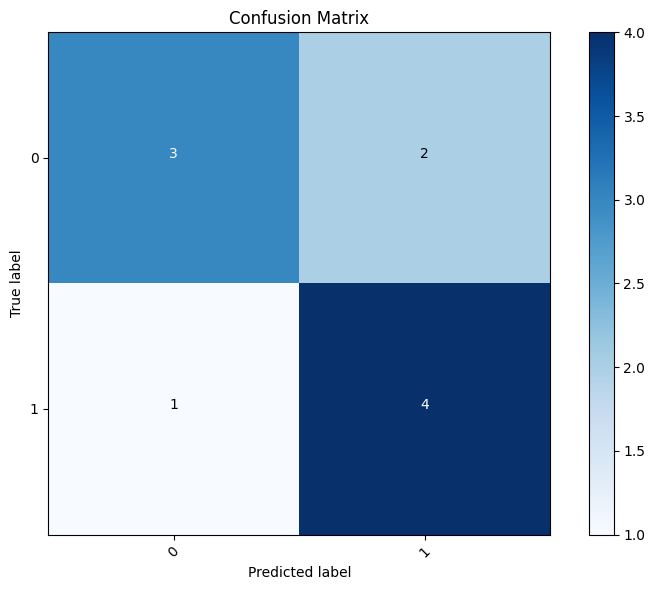

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_true and y_pred are your true and predicted labels, respectively
# Replace these with your actual true and predicted labels
y_true = np.array([1, 0, 0, 1, 1, 1, 0, 1, 0, 0])
y_pred = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1])

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix (optional)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = np.unique(y_true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()
